In [17]:
# ======================================
# 02_modeling.ipynb
# Customer Churn Project - Modeling & Evaluation
# ======================================

# 1. Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap

# Set plot style
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

## 2. Load Processed Data

We use the cleaned dataset produced during EDA to ensure:
- Consistent preprocessing
- Reproducibility
- Clear separation of concerns (EDA vs modeling)


In [19]:
DATA_PATH = "../data/processed/churn_clean.csv"
df = pd.read_csv(DATA_PATH)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## 3. Train / Test Split

- Target variable: `Churn`
- Features: all remaining columns
- Stratified split to preserve churn distribution


In [20]:
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((5634, 19), (1409, 19))

In [ ]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object"]).columns


## 4. Baseline Model: Logistic Regression

**Why Logistic Regression?**
- Interpretable coefficients
- Strong baseline for binary classification


In [21]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
        ]
    )),
    ("model", LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)

y_prob_lr = logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)


/opt/anaconda3/envs/churn-ml/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## 5. Random Forest Pipeline

- Building Random Forest pipeline
- The trees do not need scaling

In [26]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
        ]
    )),
    ("model", RandomForestClassifier(n_estimators=300, max_depth=12, class_weight="balanced",random_state=42,n_jobs=-1))
])

In [27]:
rf_pipeline.fit(X_train, y_train)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.3).astype(int)


/opt/anaconda3/envs/churn-ml/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## 6. Evaluate Models

- Define metrics funtion
- Compare LR and RF

In [28]:
def eval_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }


In [29]:
metrics_df = pd.DataFrame.from_dict({
    "Logistic Regression": eval_metrics(y_test, y_pred_lr, y_prob_lr),
    "Random Forest": eval_metrics(y_test, y_pred_rf, y_prob_rf)
}, orient="index")
metrics_df


,Accuracy,Precision,Recall,F1,ROC-AUC
Logistic Regression,0.793471,0.629283,0.540107,0.581295,0.840327
Random Forest,0.448545,0.320570,0.962567,0.480962,0.815272


## 7. Threshold Tuning for Recall

- Focus on recall for churn (catch more churners)

/opt/anaconda3/envs/churn-ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/churn-ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/churn-ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/an

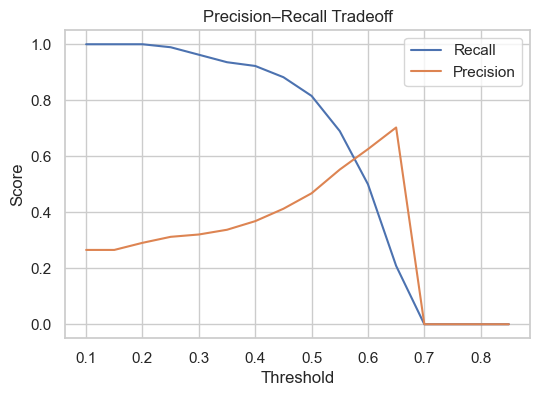

In [30]:
thresholds = np.arange(0.1, 0.9, 0.05)
recalls, precisions = [], []

for t in thresholds:
    preds = (y_prob_rf >= t).astype(int)
    recalls.append(recall_score(y_test, preds))
    precisions.append(precision_score(y_test, preds))

plt.figure(figsize=(6,4))
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, precisions, label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall Tradeoff")
plt.legend()
plt.show()


## 8. Feature Importance (Random Forest)

- Get names after preprocessing

In [31]:
rf_model = rf_pipeline.named_steps["model"]
feature_names = rf_pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
importances.head(10)


num__tenure                              0.092361
cat__Contract_Two year                   0.072037
cat__InternetService_Fiber optic         0.063755
cat__OnlineBackup_No internet service    0.060112
cat__PaymentMethod_Electronic check      0.053562
cat__StreamingTV_No internet service     0.045313
num__MonthlyCharges                      0.044445
cat__InternetService_No                  0.041082
cat__TechSupport_No internet service     0.039746
cat__OnlineSecurity_Yes                  0.037963
dtype: float64

## 9. SHAP Explainability

- Explain RF predictions

100%|===================| 11213/11268 [02:40<00:00]        

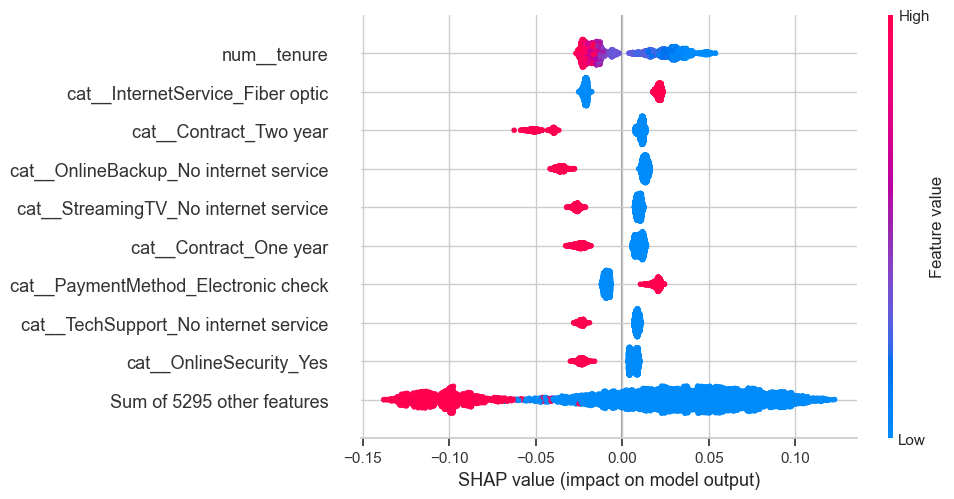

In [38]:
# ===============================
# SHAP Explainability (Binary Class Fix)
# ===============================

# 1. Transform training data
X_transformed = rf_pipeline.named_steps["preprocessor"].transform(X_train)

# 2. Convert to dense numeric array
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

X_transformed = X_transformed.astype(np.float32)

# 3. Get feature names
feature_names = (
    rf_pipeline
    .named_steps["preprocessor"]
    .get_feature_names_out()
)

# 4. Create SHAP explainer (modern API)
explainer = shap.Explainer(
    rf_pipeline.named_steps["model"],
    X_transformed,
    feature_names=feature_names
)

# 5. Compute SHAP values
shap_values = explainer(X_transformed)

# 6. Select churn class ONLY (class = 1)
shap_values_churn = shap_values[..., 1]

# 7. Global explanation plot
shap.plots.beeswarm(shap_values_churn)


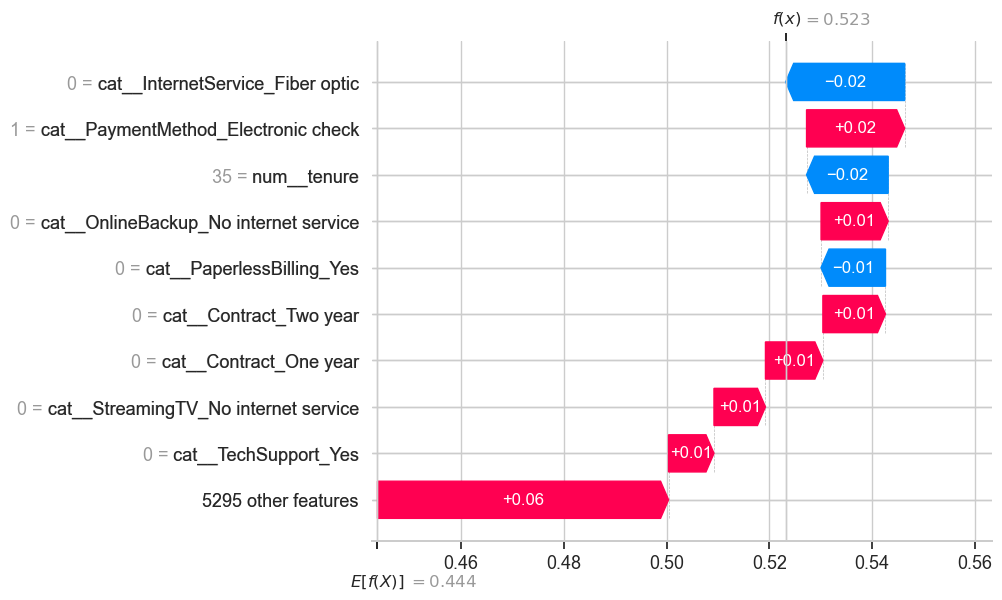

In [39]:
# Example
shap.plots.waterfall(shap_values_churn[0], max_display=10)


## Key Insights from SHAP Value Analysis

It shows which features most strongly influence the model's predictions, with several notable patterns:

Strongest Predictors:
- Tenure (num__tenure) is by far the most important feature, with consistently high positive SHAP values (mostly blue, indicating high feature values). Longer customer tenure strongly increases the predicted outcome, suggesting that established customers behave very differently from new ones.

- Fiber Optic Internet Service shows a distinct split - some customers with this service (red/high values) have strong positive impacts, while others show negative impacts. This suggests fiber optic service interacts with other factors in complex ways.

Contract and Service Patterns:
- Two-year contracts have notably negative SHAP values, meaning they decrease the prediction (likely customer churn). This makes intuitive sense - longer contracts indicate commitment and stability.
- One-year contracts also show negative impacts, though less pronounced than two-year contracts.
- Add-on services without base internet (Online Backup, Streaming TV, Tech Support) show an interesting pattern - when customers have these services without internet, it has a modest negative impact on the prediction.

Payment and Security:
- Electronic check payment shows a clear positive impact (increasing predicted churn), suggesting this payment method correlates with higher-risk customers.
- Online Security having the service (Yes) shows negative SHAP values, indicating protective effect.

The Long Tail:
The "Sum of 5295 other features" line is revealing - most features individually contribute very little to predictions. The model's predictive power comes from a relatively small number of key features, which is valuable for business decision-making and customer retention strategies.